<a href="https://colab.research.google.com/github/Konic-NLP/5922-deep-learning/blob/main/lab_assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U sentence-transformers

In [ ]:
pip install transformers

In [ ]:
import torch
from transformers import BertTokenizer,BertModel,LxmertModel,LxmertTokenizer,BartModel,BartTokenizer
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
## PART 1. Set up the VizWiz-VQA dataset

img_dir = "https://vizwiz.cs.colorado.edu//VizWiz_visualization_img/"
# split = 'train' 
split = 'val'
# split = 'test'
annotation_file = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/%s.json" %split
print(annotation_file)

https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/val.json


In [ ]:
## Visualize image given a url
from skimage import io
import matplotlib.pyplot as plt

%matplotlib inline

def visualize_image(image_url):
  image = io.imread(image_url)
  # print(image_url)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
embeddings = model.encode(data[0]['question'])


In [ ]:
def sen_extract(sentence):
  return model.encode(sentence)

In [ ]:
# Read the file to extract each dataset example with label
import requests
import numpy as np

split_data = requests.get(annotation_file, allow_redirects=True)
data = split_data.json()

In [ ]:
## Set up the model

from collections import defaultdict
# num_VQs = 500
X = [] ## features
y = [] ## target labels
images_features=[]
language_features=[]
language_features_sen=[]
all_possible_answers=set()
X_VIT=[]
fre_quent_dict=defaultdict(int)
count=0
for vq in data:
  if(len(y))==2000:
    break
  answers = vq['answers']
  all_answers=defaultdict(int)
  for answer in answers:
    all_answers[answer['answer'].lower()]+=1
  
  all_answers=sorted(all_answers.items(),key=lambda x:x[1],reverse=True)
  if fre_quent_dict.get(all_answers[0][0],0)>=3:

    continue
  else:
    fre_quent_dict[all_answers[0][0]]+=1
    
    
  # Extract features describing the image
  image_name = vq['image']
  image_url = img_dir + image_name
  # VIT model to extract
  img_emb=VIT_extract_Img(image_url)
  question = vq['question']
  q_emb=VIT_extract_lang(question)

  img=resize(image_url)
  image_feature=image_extract(img)
  images_features.append(image_feature)

  # Extract features describing the question
  question = vq['question']

  question_feature_sen = sen_extract(question)# extracted by sentence transformer
 
  question_feature=extract_question_features(question).detach().numpy()
  language_features.append(question_feature)
  language_features_sen.append(question_feature_sen)
  # # Create a multimodal feature to represent both the image and question (e.g. concatenate, multiply, etc.)
  multimodal_features = np.concatenate((question_feature, image_feature),axis=None)
  VIT_mul_feature=np.concatenate((img_emb,q_emb),axis=None)
  # Prepare features and labels
  X.append(multimodal_features)
  X_VIT.append(VIT_mul_feature)
  # answers = vq['answers']
  # all_answers=defaultdict(int)
  # for answer in answers:
  #   all_answers[answer['answer'].lower()]+=1
  
  # all_answers=sorted(all_answers.items(),key=lambda x:x[1],reverse=True)
  # print(all_answers)
  try:
    top_n=5 if len(all_answers)>=5 else len(all_answers)
  except:
    print(all_answers)   
  
  
  answer_set=set(list( x[0] for x in all_answers)[:top_n])
  # for x in list(all_answers)[:top_n]:
    # print(x[0])
    # fre_quent_dict[x[0]]+=1
  # print(answer_set)
  all_possible_answers=all_possible_answers.union(answer_set)
  gold_label = all_answers[0][0]
  y.append(gold_label)

  # Print and visualize samples and features
  print(image_name)
  # print(question)
  # print(gold_label)
  # print(all_possible_answers)
  # print(multimodal_features.shape)
  # visualize_image(image_url)
# print(len(all_possible_answers))

data serilization and persistance

In [ ]:
import pickle

In [ ]:
f=open('/content/drive/MyDrive/img_feature_train','rb')
images_features_train=pickle.load(f)

# print(len(all_possible_answers_val),type(all_possible_answers_val))
f.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# serilized some data in order to reuse
with open('/content/drive/MyDrive/input_train_balanced','wb') as f:
  pickle.dump(X_VIT,f)

In [ ]:
# de-serilize the data
f=open('/content/drive/MyDrive/output_val','rb')
y_val=pickle.load(f)

# print(len(all_possible_answers_val),type(all_possible_answers_val))
f.close()

In [ ]:
f=open('/content/drive/MyDrive/image_feature_val','rb')
images_features_val=pickle.load(f)

# print(len(all_possible_answers_val),type(all_possible_answers_val))
f.close()

In [ ]:
f=open('/content/drive/MyDrive/language_feature_val','rb')
question_features_val=pickle.load(f)

# print(len(all_possible_answers_val),type(all_possible_answers_val))
f.close()

In [ ]:
f=open('/content/drive/MyDrive/question_feature_train','rb')
question_features_train=pickle.load(f)

# print(len(all_possible_answers_val),type(all_possible_answers_val))
f.close()

In [ ]:
# look at the label distribution and find the imbalanced labels issue
from collections import Counter
from functools import reduce
counter=Counter
dic=counter(y_train)
print(len(dic))
print(type(dic))
print(type(dic.values()))
for k,v in sorted(dic.items(),key=lambda x:x[1],reverse=True):
  print(k,v)
# print(sum(dic.values()))
print(reduce(lambda x,y:x+y,dic.values()))


In [ ]:
X=[]
for k,v in zip(images_features_train,question_features_train):
  X.append(np.concatenate((k,v),axis=None))

In [ ]:
X=[]
for x,y in zip(images_features_train,question_features_train):
  multimodal_features=np.concatenate((x,y),axis=None)
  X.append(multimodal_features)

In [ ]:
f=open('/content/drive/MyDrive/input_val','rb')
X_val=pickle.load(f)

# print(len(all_possible_answers_val),type(all_possible_answers_val))
f.close()

In [ ]:
f=open('/content/drive/MyDrive/output_val','rb')
y_val=pickle.load(f)

# print(len(all_possible_answers_val),type(all_possible_answers_val))
f.close()

In [ ]:
f=open('/content/drive/MyDrive/output_train_balanced','rb')
y_train=pickle.load(f)

# print(len(all_possible_answers_val),type(all_possible_answers_val))
f.close()

sevral feature extractor 

In [ ]:
def extract_question_features(questions):
  inputs=tokenizer(questions,return_tensors="pt")
  output=bert(**inputs)
  language_feature=output.pooler_output
  # print(language_feature.shape)
  # language_feature=language_feature
  return language_feature

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.preprocessing import image
from matplotlib import pyplot as plt

# vgg_model = VGG16(weights='imagenet', include_top=True)
# vgg_model.summary()

## Call image from a url
from PIL import Image
from urllib import request
from io import BytesIO

In [ ]:
def resize(image_url):
  res = request.urlopen(image_url).read()
  img = Image.open(BytesIO(res)).resize((224,224))
  return img

In [ ]:
from keras.models import Model
vggmodel = VGG16(weights='imagenet', include_top=True)
# model.summary()
vgg_model = Model(inputs = vggmodel.inputs, outputs = vggmodel.layers[-2].output )
def image_extract(img):
  img_data = image.img_to_array(img)
  img_data = np.expand_dims(img_data, axis=0)
  img_data = preprocess_input(img_data)
  feature_maps = vgg_model.predict(img_data)
  return feature_maps

553476096/553467096 [==============================] - 7s 0us/step


get the label space

In [ ]:
all_possible_answers=all_possible_answers.union(all_possible_answers_val)
print(len(all_possible_answers))

5362


In [ ]:
y_train=y

In [ ]:
all_possible_answers=y_train+y_val

In [ ]:
# convert the text feature into discrete value
import keras_preprocessing
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

# all_possible_answers=list(all_possible_answers)
all_possible_answers=list(set(all_possible_answers))
ansers_set=encoder.fit_transform(all_possible_answers)
# print(encoder.inverse_transform(all_possible_answers))
# print(encoder.inverse_transform(y))
# all_possible_answers=encoder.fit_transform(list(all_possible_answers))
# print(y,all_possible_answers)
y_train=encoder.transform(y_train)
y_val=encoder.transform(y_val)

In [ ]:
# convert each value to a one-hot vector
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
train_labels=to_categorical(y_train,num_classes=len(all_possible_answers))
val_lables=to_categorical(y_val,num_classes=len(all_possible_answers))

The classfier and experiment

In [ ]:
X,y_train,X_val,y_val=np.array(X),np.array(train_labels),np.array(X_val),np.array(val_lables)

In [ ]:
print(X.shape,y_train.shape,X_val.shape,y_val.shape)

(2000, 4864) (2000, 995) (500, 4864) (500, 995)


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
# from keras.layers import Dense
from keras.layers.core import Dropout
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=(4864)))

# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(995, activation='softmax'))
#attention that the final class

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

# from keras.callbacks import ModelCheckpoint
filepath="weights-best-sen.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
mode='min')
callbacks_list = [checkpoint]
opt = tf.keras.optimizers.Adam(learning_rate=1e-05)
model.compile(loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy'])
hist=model.fit(X,train_labels,
  epochs=20,
  batch_size=128,validation_data=(X_val, val_lables),callbacks=callbacks_list)

In [ ]:
#predict the test and convert the idnex to the label class
result=model.predict(X_test)
y_test_pred = np.argmax(result, axis=1)
# y_test_gold= np.argmax(y_val, axis=1)
result=encoder.inverse_transform(y_test_pred)

In [ ]:
print(result)

['grey' 'unanswerable' 'no' 'no' 'unanswerable' 'unanswerable' 'black'
 'no' 'unanswerable' 'unanswerable' 'unsuitable' 'no' 'white' 'no'
 'unsuitable' 'no' 'no' 'unanswerable' 'unanswerable' 'unanswerable'
 'grey' 'no' 'unanswerable' 'no' 'no' 'no' 'unsuitable' 'unanswerable'
 'unsuitable' 'unanswerable' 'unanswerable' 'unanswerable' 'no'
 'unanswerable' 'no' 'unanswerable' 'unanswerable' 'unanswerable'
 'unanswerable' 'no' 'no' 'grey' 'unanswerable' 'unanswerable'
 'unsuitable' 'no' 'unanswerable' 'unanswerable' 'dog' 'no' 'unanswerable'
 'unanswerable' 'unanswerable' 'unanswerable' 'no' 'grey' 'no' 'grey'
 'unsuitable' 'unsuitable' 'yes' 'grey' 'black' 'no' 'unanswerable'
 'unanswerable' 'unanswerable' 'unanswerable' 'unanswerable'
 'unanswerable' 'no' 'no' 'unanswerable' 'no' 'unanswerable' 'no'
 'unanswerable' 'no' 'no' 'unanswerable' 'no' 'unanswerable' 'no'
 'unanswerable' 'unanswerable' 'unsuitable' 'unanswerable' 'unanswerable'
 'unanswerable' 'unsuitable' 'unanswerable' 'grey

In [ ]:
print(list(result).count('unanswerable')/500)

0.92


In [ ]:
gtlist = [x['answers'] for x in data]

# Save the accuracies
acc_list = []
i = 0

# Compute accuracy for each image
for pred in result:

    # Get the GT answer list and preprocess
    gt_ans = gtlist[i] 
    gt_ans = [x['answer'] for x in gt_ans]
    gt_ans = [x.lower() for x in gt_ans]

    # Compute accuracy (compare with at least 3 human answers)
    cur_acc = np.minimum(1.0, gt_ans.count(pred)/3.0)

    acc_list.append(cur_acc)
    i +=1

print ('Accuracy: {}'.format(round(np.mean(acc_list), 2)))

Accuracy: 0.25


In [ ]:
# draw the loss curve
def drawplot(name,modelfordraw):
  plt.plot(modelfordraw.history["loss"], color ="green", label = "train_loss")

  # plt.plot(trained_model_base.history["val_loss"], color ="red", label = "base-test")
  plt.plot(modelfordraw.history["val_loss"], color ="orange", label = "val_loss")

  plt.title(name)
  plt.ylabel("loss")
  plt.xlabel("Number of epochs")
  plt.legend()
  plt.show()

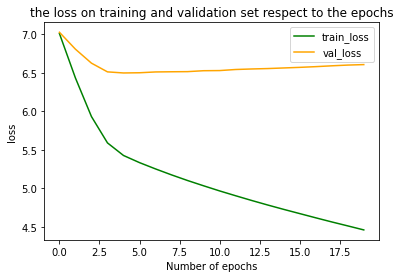

In [ ]:
drawplot("the loss on training and validation set respect to the epochs",hist)

In [ ]:
!pip install ftfy

     |████████████████████████████████| 53 kB 1.3 MB/s 


In [ ]:
# the VIT extractor
from PIL import Image
from urllib import request
from sentence_transformers import SentenceTransformer, util
from io import BytesIO
#Load CLIP model
VITmodel = SentenceTransformer('clip-ViT-B-32')
def VIT_extract_Img(image_name):
  res = request.urlopen(image_name).read()
#Encode an image:
  img = Image.open(BytesIO(res))
  img_emb = VITmodel.encode(img)
  img_emb=np.array(img_emb)
  return img_emb

#Encode text descriptions
def VIT_extract_lang(question):
  text_emb = VITmodel.encode(question)
  return text_emb



In [ ]:
img_emb=VIT_extract_Img(image_name)
q_emb=VIT_extract_lang(data[0]['question'])
print(img_emb.shape,q_emb.shape)
print(np.concatenate((img_emb,q_emb),axis=None))

(512,) (512,)
[-2.7930737e-04 -9.1579288e-02  1.5963916e-01 ... -5.9106541e-01
 -1.3380298e-01  7.0923150e-02]
